# Recipe dataset obtained from opencrawl
Using spark we filtered recipes from the open crawl index(of july 2016), we made use of the json+ld and microdata format  [schema.org](http://schema.org/Recipe). We saved the results into 500 json files with a recipe document on each line. Also we determined the language for each webpage crawled, either by looking at useful html-tags or using a [language detector](https://github.com/optimaize/language-detector). These document are then loaded into a mongodb database for easy querying. Also during import we calculate number of ingredients per recipe and max number of chars for all the ingredients per recipe.

In [1]:
import sys
sys.path.append("../code/")
from config import get_mongo_db
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import OrderedDict
db = get_mongo_db()
from IPython.display import HTML, display
%matplotlib inline
total_recipe_count = db.recipes.count()
display(HTML("<strong>We found %d recipes in total </strong>" % total_recipe_count))

## Some  examples(in english)
Here we show some random recipe examples

In [30]:
def tablify(d):
    h = "<table>"
    for k,t in d.iteritems():
        h += "<tr><td><strong>%s</strong></td><td>%s</td></tr>" % (k,t)
    h += "</table>"
    return h

def listify(l):
    if l is None or len(l) ==0:
        return "<i>None</i>"
    h = "<ul>"
    h += "".join(["<li>%s</li>" % s for s in l ])
    h += "</ul>"
    return h
    

def print_recipe(m):
    html = "<h5>%s</h5>" % m['name']
    con = m['context']
    #con['url'] = '<a href="%s" target="_blank">%s</a>' % (con['url'], "Recipe link")
    html += "<p>" + " ".join(["<strong>%s:</strong> %s" % (k,v) for k,v in m['context'].iteritems()]) + "</p>"
    html += "<table style=\"text-align:left\"><thead>"
    html += "<tr>"
    if "image" in m:
        html += "<td><strong>Image</strong></td>"
    
    html += "<td><strong>General</strong></td><td><strong>Ingredients</strong></td><td><strong>Nutrition</strong></td></tr></thead><tbody>"
    c = m['context']
    c['url'] = '<a href="%s" target="_blank">Recipe</a>' % c['url']
    generals = [(k,v) for k,v in m.iteritems() if k in ['recipeYield','cookingMethod','cookTime','prepTime','totalTime','recipe_size']]
    if 'ratings' in m:
        generals.extend([(k,v) for k,v in m['ratings'].iteritems() if k in ['aggregateCount','aggregateRating']])
        if 'reviews' in m['ratings']:
            generals.append(("Number of reviews",len(m['ratings']['reviews'])))
    general_html = tablify(dict(generals))
    if 'nutritionInfo' in m:
        nutr_html = tablify(m['nutritionInfo']) 
    else:
        nutr_html = "<i>None</i>"
    ingredients_html = "<ul>"+"".join("<li>%s</li>" % i for i in m['ingredients'] )+"</ul>"
    html += "<tr>"
    if 'image' in m:
        html += "<td><img width=200 src=\"%s\"></td>" % m['image']
    html += "<td>"+general_html+"</td><td>"+ingredients_html+"</td><td>"+nutr_html+"</td></tr>"
    html += "</tbody></table>"
    
    html += "<table><thead><tr><td><strong>Category</strong></td><td><strong>Cuisine</strong></td><td><strong>diets</strong></td></tr></thead><tbody>"
    html += "<tr><td>" + listify(m['category']) + "</td><td>" + listify(m['cuisine']) + "</td><td>" + listify(m['diets'])+ "</td></tr>"
    html += "</tbody></table>"
    
    html += "<p><strong>Description: </strong>%s</p>" % (" <i>Geen</i>" if 'description' not in m else m['description'] )
    html += "<p><strong>Instructions: </strong>%s</p>" % (" <i>Geen</i>" if 'instructions' not in m else m['instructions'] )
    display(HTML(html))


In [55]:
#Random sample 10 recipes that have language en
recipes = db.recipes.aggregate([{"$sample": {"size":1}}])
for r in recipes:
    #print r.keys()
    print_recipe(r)

## Statistics

In [2]:
def plot_hist(d,label=""):
    plt.bar(range(len(d)), d.values(), align='center',label=label)
    plt.xticks(range(len(d)), d.keys(), rotation=25)
    
def sorted_counts(results,by_key=False):
    counts = [(x['_id'], x['count']) for x in results]
    counts = sorted(counts, key=itemgetter(0 if by_key else 1),reverse=not(by_key))
    return counts

def print_percentages(counts, percent=[.9,.95,.975,.99,.999]):
    total = float(sum(counts.values()))
    till_now = 0
    for x,y in counts.iteritems():
        till_now += y
        if till_now/total >= percent[0]:
            print x,percent[0]
            percent = percent[1:]
            
        
        if len(percent) < 1:
            break
 

### Top 20 most occuring languages
The fast majority of the documents are in english

English accounts for 2480433 of the recipes. 249839 Could not be identified 


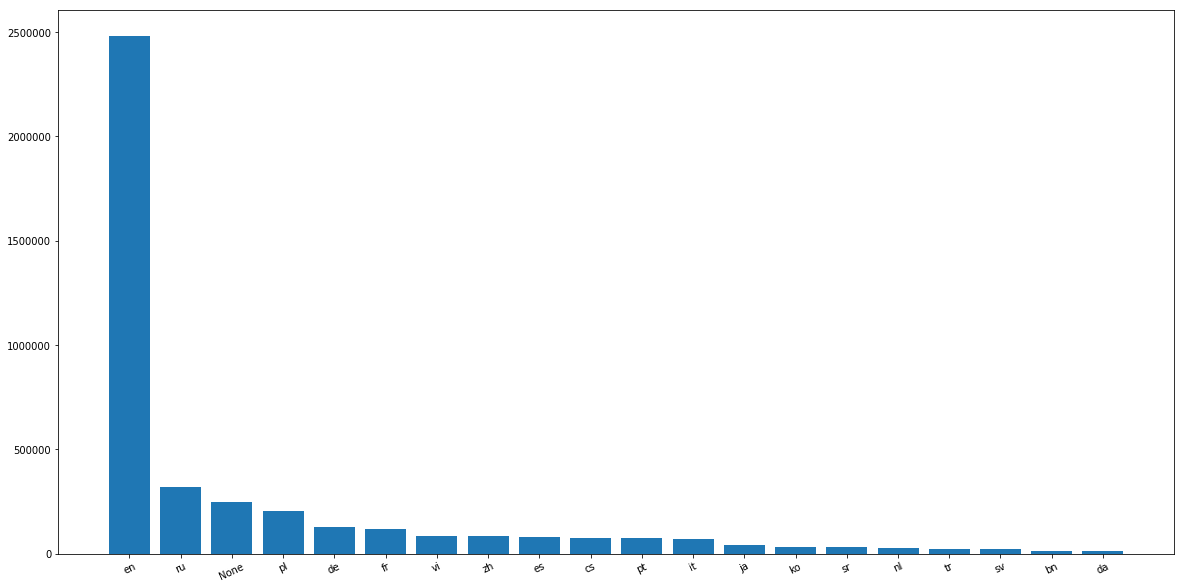

In [3]:
results = db.recipes.aggregate([{"$group": {"_id": "$context.language","count":{ "$sum": 1 }}}])
counts = sorted_counts(results)
counts_top = OrderedDict(counts[:20]) # take top 25
print "English accounts for %d of the recipes. %d Could not be identified " % (counts_top['en'],counts_top[None]) 
plt.figure(figsize=(20,10))
plot_hist(counts_top)
plt.show()

### Top 20 domains (all, english)

Most used domain is www.food.com, with 286065 recipes
The top 20 domain account for 1688376  recipes


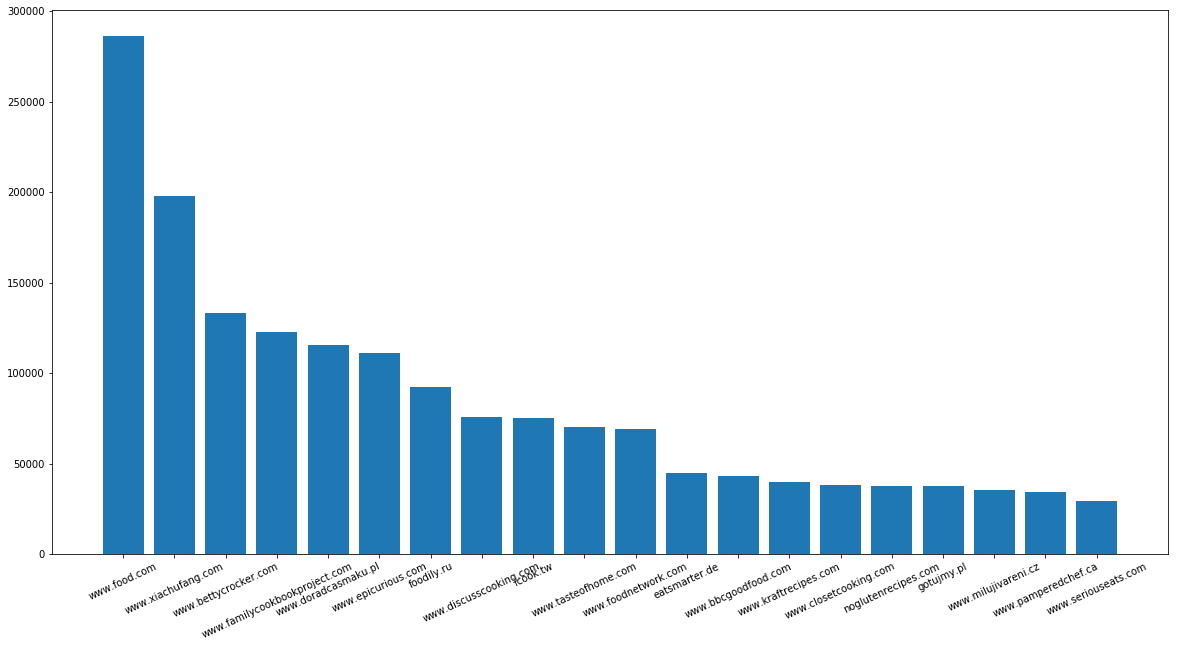

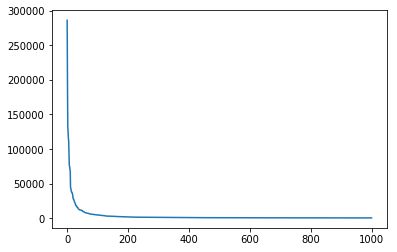

In [4]:
results = db.recipes.aggregate([{"$group": {"_id": "$context.host","count":{ "$sum": 1 }}}])
counts = sorted_counts(results)
counts_top_20 = OrderedDict(counts[:20]) # take top 25
best =  counts_top_20.keys()[0]
print "Most used domain is %s, with %d recipes" % (best, counts_top_20[best])
print "The top 20 domain account for %d  recipes" % sum(counts_top_20.values())
plt.figure(figsize=(20,10))
plot_hist(counts_top_20)
plt.show()
counts_all = OrderedDict(counts)
plt.plot(counts_all.values()[:1000])
plt.show()

Most used domain is www.food.com, with 286026 recipes
The top 20 domain account for 1202763  recipes


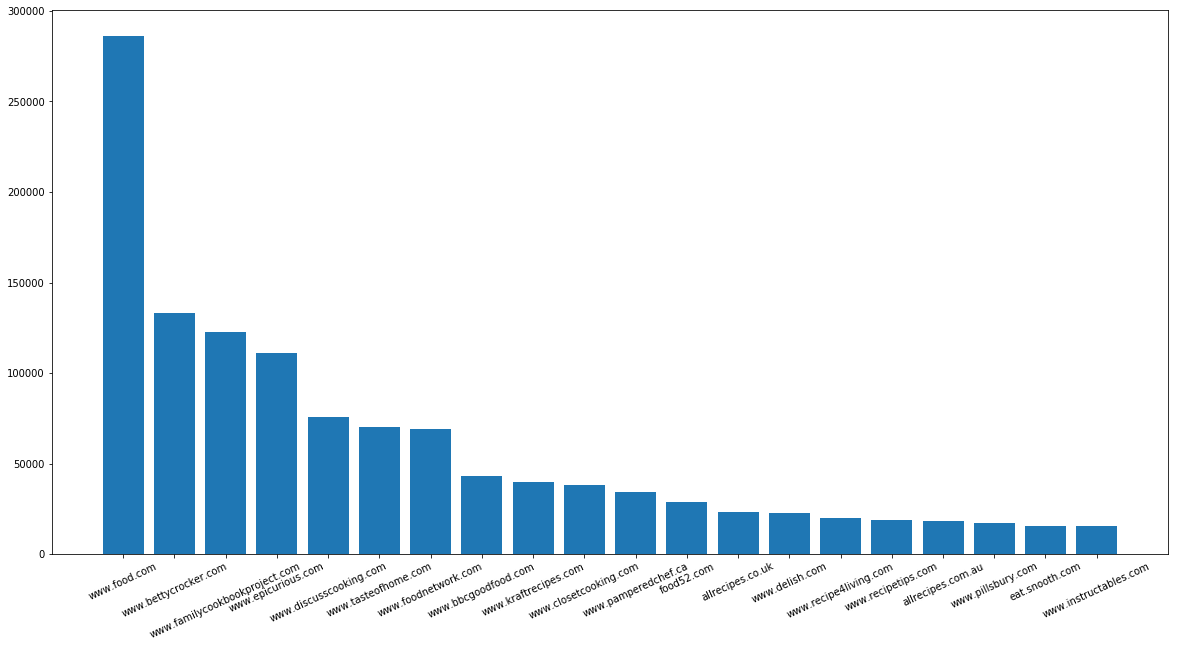

In [5]:
results = db.recipes.aggregate([{"$match":{'context.language':"en"}},{"$group": {"_id": "$context.host","count":{ "$sum": 1 }}}])
counts = sorted_counts(results)
counts_top_20 = OrderedDict(counts[:20]) # take top 20
best =  counts_top_20.keys()[0]
print "Most used domain is %s, with %d recipes" % (best, counts_top_20[best])
print "The top 20 domain account for %d  recipes" % sum(counts_top_20.values())
plt.figure(figsize=(20,10))
plot_hist(counts_top_20)
plt.show()


### Ingredient and recipe size(in english)
For our convolutional based algorithm we need the limit the number of characters per ingredient and the number of ingredients per recipe.

In english about 2210711 recipes have at least 1 ingredients defined. In total 21435638 ingredients are defined


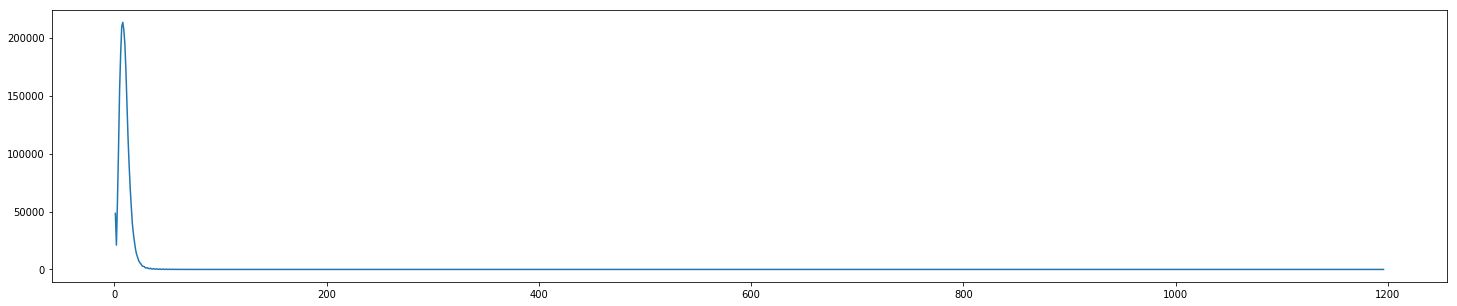

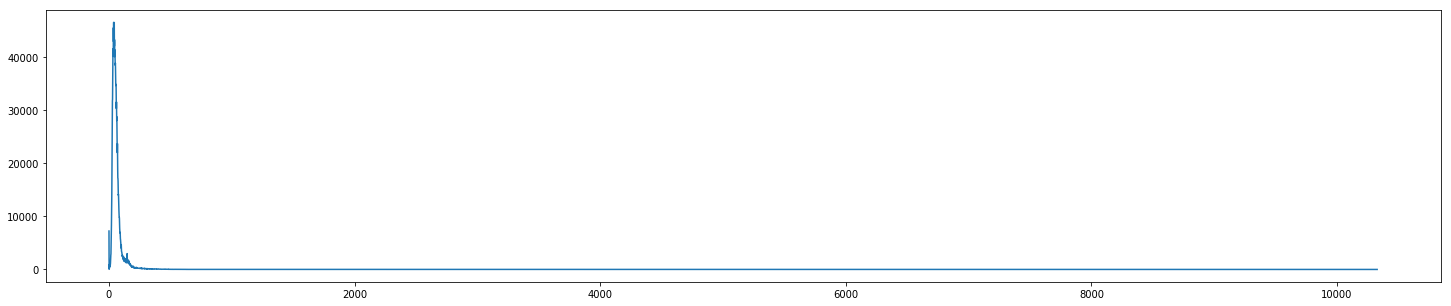

16 0.9
18 0.95
21 0.975
25 0.99
45 0.999


94 0.9
138 0.95
178 0.975
290 0.99
865 0.999


In [7]:
recipe_sizes = db.recipes.aggregate([{"$match":{"recipe_size":{"$gt":0},"context.language":"en"}},{"$group": {"_id": "$recipe_size","count":{ "$sum": 1 }}}])
max_ingredient_size = db.recipes.aggregate([{"$match":{"recipe_size":{"$gt":0},"context.language":"en"}},{"$group": {"_id": "$max_ingredient_size","count":{ "$sum": 1 }}}])
counts_rs = OrderedDict(sorted_counts(recipe_sizes,True))
counts_mis = OrderedDict(sorted_counts(max_ingredient_size,True))
at_least_one = sum(counts_rs.values())
total_ingredients = sum([x*y for x,y in counts_rs.iteritems()])
print("In english about %d recipes have at least 1 ingredients defined. In total %d ingredients are defined" % (at_least_one,total_ingredients) )
plt.figure(figsize=(25,5))
plt.plot(counts_rs.keys(), counts_rs.values())
plt.show()
plt.figure(figsize=(25,5))
plt.plot(counts_mis.keys(), counts_mis.values())
plt.show()
display(HTML("<h5>Percentages covering certain recipe size</h5>"))
print_percentages(counts_rs)
display(HTML("<h5>Percentages covering certain max ingredient size</h5>"))
print_percentages(counts_mis)

## Nutrition information

Not all recipes involved have nutrition information defined. Also the nutrition information provided could be about the whole recipe or just per serving. This information usually is present in the recipeYield(defined in parent documents) or the servingSize field(defined in nutritionInfo subdocument).

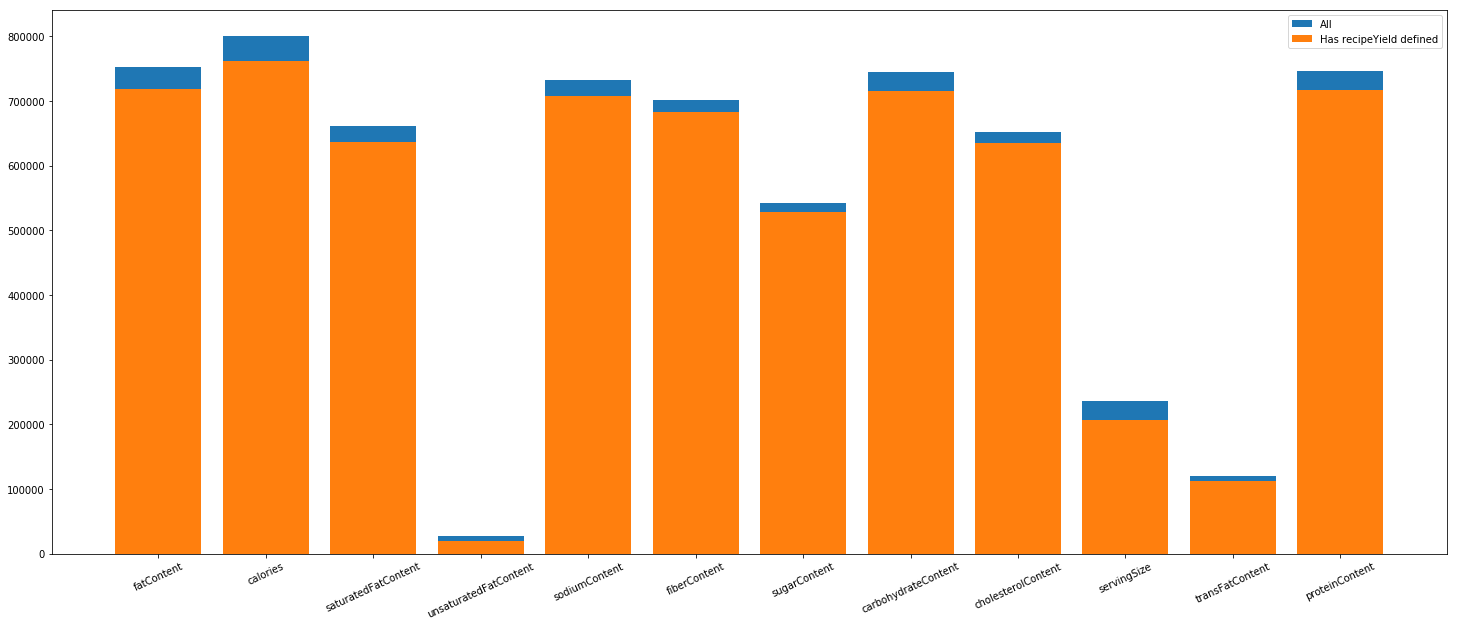

In [8]:
attrs = ['carbohydrate','cholesterol','fat','fiber','protein','saturatedFat','sodium','sugar','transFat','unsaturatedFat']
attrs = [c+"Content" for c in attrs]
attrs = ["calories", "servingSize"] + attrs
nutr = {}
nutr_rc = {}
for a in attrs:
    c = db.recipes.find({"context.language":"en",("nutritionInfo.%s"%a):{"$ne":None}}).count()
    c2 = db.recipes.find({"context.language":"en","recipeYield":{"$ne":None},("nutritionInfo.%s"%a):{"$ne":None}}).count()
    nutr[a] = c
    nutr_rc[a] = c2
plt.figure(figsize=(25,10))
plot_hist(nutr,label="All")
plot_hist(nutr_rc,label="Has recipeYield defined")
plt.legend()

### Intersects
There seems to be quite some overlap between the different classes, if the largest class is defined carbohydrateContent and proteinContent also is usually defined

In [13]:
def find_union(fields):
    query = [{(("nutritionInfo.%s") % f):{"$ne":None}} for f in fields]
    C = db.recipes.find({"context.language":"en","recipeYield":{"$ne":None}, "$or":query}).count()
    return C

def find_intersect(fields):
    query = [{(("nutritionInfo.%s") % f):{"$ne":None}} for f in fields]
    C = db.recipes.find({"context.language":"en","recipeYield":{"$ne":None}, "$and":query}).count()
    return C

union_count = find_union(attrs)
c = db.recipes.find({"context.language":"en","recipeYield":{"$ne":None},("nutritionInfo.calories"):{"$ne":None}}).count()

print("The attribute with highest availability is calories with %d occurences, %d recipes have at least one of the attributes defined" % (c, union_count ))
print("%d recipes have either calories or proteinContent defined. %d have both defined" % (find_union(['calories','proteinContent']),find_intersect(['calories','proteinContent'])))
print("%d recipes have either calories,proteinContent or carbohydrate defined. %d have all defined" % (find_union(['calories','proteinContent','carbohydrateContent']),find_intersect(['calories','proteinContent'])))

The attribute with highest availability is calories with 760963 occurences, 778254 recipes have at least one of the attributes defined
761201 recipes have either calories or proteinContent defined. 716385 have both defined
761644 recipes have either calories,proteinContent or carbohydrate defined. 716385 have all defined


### Calories defined per domain
One reasonable assumption is that the nutrtionInformation will be defined(as in terms of per serving or something) the same way per domain. Below we show the top 25 of the domains where the calorie information together with recipe yield occurs the most.


The top 25 domain account for 676816  recipes out of 760963 recipes 


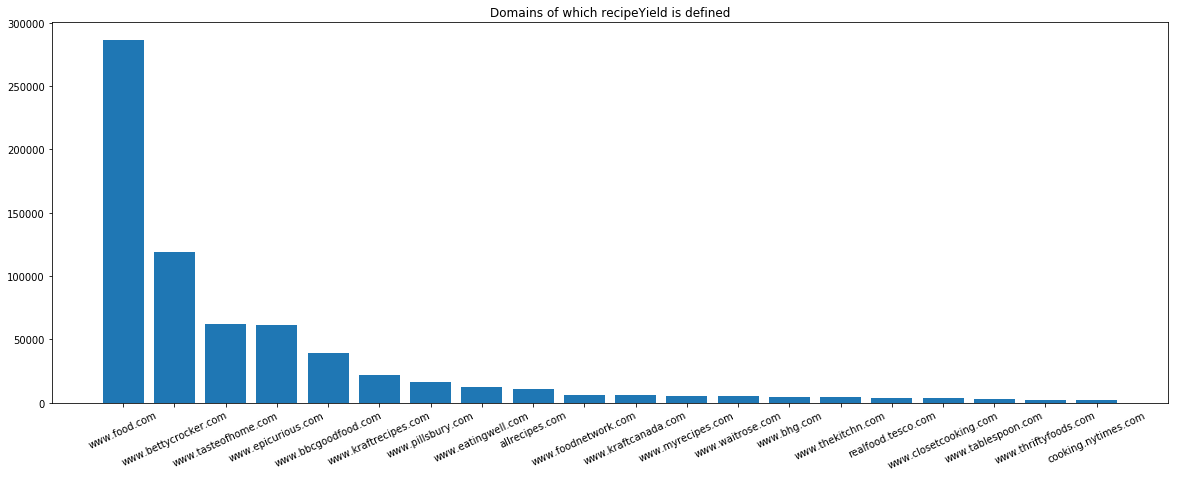

In [11]:
# All recipes that have have calories defined and also have recipeYield defined
results = db.recipes.aggregate([{"$match":{"$and":[{"nutritionInfo.calories":{"$ne":None}},{"context.language":"en"},{"recipeYield":{"$ne":None}}]}},{"$group": {"_id": "$context.host","count":{ "$sum": 1 }}}])
counts = sorted_counts(results)
counts_top_20 = OrderedDict(counts[:20]) # take top 25
print "The top 25 domain account for %d  recipes out of %d recipes " % (sum(counts_top_20.values()), sum(dict(counts).values()))
plt.figure(figsize=(20,7))
plt.title("Domains of which recipeYield is defined")
plot_hist(counts_top_20)
plt.show()

[u'www.food.com', u'www.bettycrocker.com', u'www.epicurious.com', u'www.tasteofhome.com', u'www.bbcgoodfood.com', u'www.kraftrecipes.com', u'www.pillsbury.com', u'eda.ru', u'www.eatingwell.com', u'allrecipes.com', u'www.foodnetwork.com', u'www.kraftcanada.com', u'www.waitrose.com', u'www.myrecipes.com', u'www.bhg.com', u'www.thekitchn.com', u'www.ilewazy.pl', u'realfood.tesco.com', u'www.closetcooking.com', u'www.tablespoon.com', u'www.thriftyfoods.com', u'cooking.nytimes.com', u'www.finecooking.com', u'www.absolutdrinks.com', u'www.thespruce.com']
The top 25 domain account for 713805  recipes out of 816453 domains 


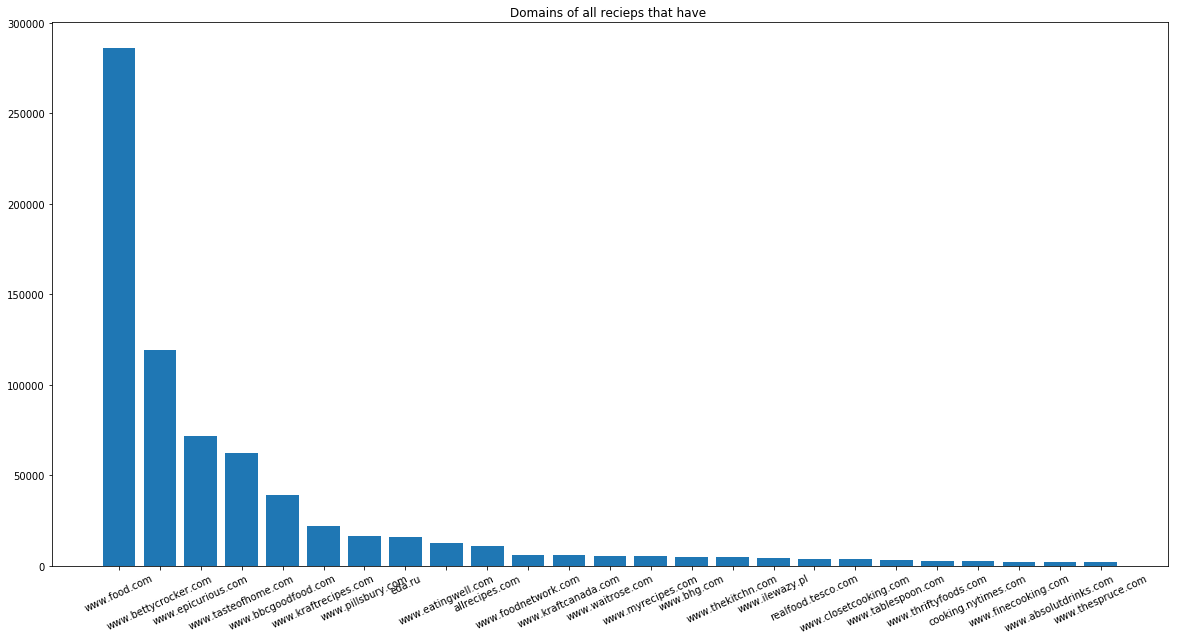

In [12]:
# All recipes that have calories defined
results = db.recipes.aggregate([{"$match":{"$and":[{"nutritionInfo.calories":{"$ne":None}},{"context.language":"en"}]}},{"$group": {"_id": "$context.host","count":{ "$sum": 1 }}}])
counts = sorted_counts(results)
counts_top_25 = OrderedDict(counts[:25]) # take top 25
print counts_top_25.keys()
print "The top 25 domain account for %d  recipes out of %d domains " % (sum(counts_top_25.values()), sum(dict(counts).values()))
plt.figure(figsize=(20,10))
plt.title("Domains of all recieps that have ")
plot_hist(counts_top_25)
plt.show()

### Random sample of recipeYield
We have a look at our recipeYield field, we see that for www.food.com there seems to be a mistake in the 2016-7 crawl. Also we see that in most of the cases the recipeYield contains the number of servings, where the nutrtionInformation describes just the caloric input.

In [6]:
recipes = db.recipes.aggregate([{"$match":{"diets":"http://schema.org/VegetarianDiet"}}, {"$sample": {"size":10}}])